# TL;DR In-depth Analysis

## Preprocessing

In [34]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from eval_funcs import *

In [35]:
wikihow_subset = pd.read_csv('./datasets/wikihow_sep_subset.csv')

In [36]:
wikihow_subset.head(45)

,text_id,sentence,is_summary,words,title,sentence_len,tfidf_score,title_similarity,title_sim_categories,may,...,want,many,ask,good,find,work,go,include,important,know
0,176320,Sell yourself first,1,"['Sell', 'yourself', 'first']",How to Sell Fine Art Online,3,2.208904,0.828910,Strong,0,...,0,0,0,0,0,0,0,0,0,0
1,176320,"Before doing anything else, stop and sum up yo...",0,"['Before', 'doing', 'anything', 'else,', 'stop...",How to Sell Fine Art Online,12,4.242620,0.806864,Strong,0,...,0,0,0,0,0,0,0,0,0,0
2,176320,"Now, think about how to translate that to an o...",0,"['Now,', 'think', 'about', 'how', 'to', 'trans...",How to Sell Fine Art Online,11,2.700872,0.857768,Strong,0,...,0,0,0,0,0,0,0,0,0,0
3,176320,"Be it the few words, Twitter allows you or an ...",0,"['Be', 'it', 'the', 'few', 'words,', 'Twitter'...",How to Sell Fine Art Online,21,2.551936,0.815038,Strong,0,...,0,0,0,0,0,0,0,0,0,0
4,176320,Bring out the most salient features of your cr...,0,"['Bring', 'out', 'the', 'most', 'salient', 'fe...",How to Sell Fine Art Online,18,4.182040,0.789926,Strong,0,...,0,0,0,0,0,0,0,0,0,0
5,176320,Make it clear to readers why you are an artist...,0,"['Make', 'it', 'clear', 'to', 'readers', 'why'...",How to Sell Fine Art Online,24,4.577154,0.867380,Strong,0,...,0,0,0,0,0,0,0,0,0,0
6,176320,"If you re not great with words, find a friend ...",0,"['If', 'you', 're', 'not', 'great', 'with', 'w...",How to Sell Fine Art Online,29,4.299002,0.840578,Strong,0,...,0,0,0,0,0,0,0,0,0,0
7,12342,Read the classics before,1,"['Read', 'the', 'classics', 'before']",How to Be Well Read,4,4.168238,0.790482,Strong,0,...,0,0,0,0,0,0,0,0,0,0
8,12342,Reading the classics is the very first thing y...,0,"['Reading', 'the', 'classics', 'is', 'the', 'v...",How to Be Well Read,16,3.720692,0.958614,Very Strong,0,...,0,0,0,0,0,0,0,0,0,0
9,12342,If you want to build a solid foundation for yo...,0,"['If', 'you', 'want', 'to', 'build', 'a', 'sol...",How to Be Well Read,33,4.493084,0.919967,Very Strong,0,...,0,0,0,0,0,0,0,0,0,0


In [37]:
# Features to keep
features = wikihow_subset[['text_id','title','sentence', 'is_summary','sentence_len','tfidf_score', 'title_similarity']]

In [38]:
#Visulatize the class distribution
features['is_summary'].value_counts()

0    83417
1    16583
Name: is_summary, dtype: int64

In [39]:
#Computing null accuracy 
null_accuracy = 83417/(83417+16583)
null_accuracy

0.83417

## Performing Cross-Validation on CountVectorizer and MultinomialNB

In [40]:
# Splitting the dataset 
from sklearn.model_selection import train_test_split
X = features[['text_id','sentence', 'sentence_len', 'tfidf_score','title_similarity']]
y = features['is_summary']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [41]:
X_train_no_feat = X_train['sentence']
X_test_no_feat = X_test['sentence']

In [42]:
#Performing Cross Validation for the best combination of parameters
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.pipeline import Pipeline
# Define a pipeline combining a text feature extractor with a simple classifier
pipeline = Pipeline([
    ('vect', CountVectorizer(stop_words='english')),
    ('nb', MultinomialNB()),
])


parameters = {
    'vect__min_df': (2, 5, 10, 15, 20, 30, 40, 50),
    'vect__ngram_range': ((1, 1), (1, 2)),  # unigrams or bigrams
    'nb__alpha': (0.1, 1, 5, 10, 50),
}

In [43]:
# Find the best parameters for both the feature extraction and the classifier
grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1, scoring = 'f1')

In [44]:
print("Performing grid search...")
print("pipeline:", [name for name, _ in pipeline.steps])
print("parameters:")
print(parameters)
grid_search.fit(X_train_no_feat, y_train)
print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Performing grid search...
pipeline: ['vect', 'nb']
parameters:
{'vect__min_df': (2, 5, 10, 15, 20, 30, 40, 50), 'vect__ngram_range': ((1, 1), (1, 2)), 'nb__alpha': (0.1, 1, 5, 10, 50)}
Fitting 5 folds for each of 80 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  8.5min finished


Best score: 0.432
Best parameters set:
	nb__alpha: 0.1
	vect__min_df: 2
	vect__ngram_range: (1, 2)


## Creating a BOW model with the best parameters 

In [45]:
vectorizer = CountVectorizer(ngram_range=(1, 2), min_df=2)
Xtrain_dtm = vectorizer.fit_transform(X_train_no_feat)
Xtrain_dtm_dense = Xtrain_dtm.toarray() 
Xtrain_dtm_dense

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [46]:
# transform testing data (using fitted vocabulary) into a document-term matrix
X_test_dtm = vectorizer.transform(X_test_no_feat)
X_test_dtm

<30000x99756 sparse matrix of type '<class 'numpy.int64'>'
	with 675443 stored elements in Compressed Sparse Row format>

## Using Multinomial Naive Bayes with the best parameters

In [47]:
best_nb = MultinomialNB(alpha = 0.1)

In [48]:
# train the model using X_train_dtm
best_nb.fit(Xtrain_dtm, y_train)

MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True)

In [49]:
# make class predictions for X_test_dtm
y_pred_class = best_nb.predict(X_test_dtm)

In [50]:
# calculate performance metrics
from sklearn import metrics
print(f'Confusion Matrix: \n {metrics.confusion_matrix(y_test, y_pred_class)}')

Confusion Matrix: 
 [[23539  1528]
 [ 2018  2915]]


In [51]:
print(f'Classification Report: \n\n {metrics.classification_report(y_test, y_pred_class)}')

Classification Report: 

               precision    recall  f1-score   support

           0       0.92      0.94      0.93     25067
           1       0.66      0.59      0.62      4933

    accuracy                           0.88     30000
   macro avg       0.79      0.76      0.78     30000
weighted avg       0.88      0.88      0.88     30000



Low recall, high precision -> classifier is very picky and misses a lot of actual summary sentences.

In [52]:
print(f'Accuracy: {metrics.accuracy_score(y_test, y_pred_class)}')

Accuracy: 0.8818


Our model performs slightly better than the null accuracy, we will need to do some parameter tuning and add some features in order to improve it.

In [53]:
# false positive summaries (non summaries incorrectly classified as summaries)
X_test[y_pred_class > y_test].head()

,text_id,sentence,sentence_len,tfidf_score,title_similarity
92991,45396,"You can use a denture cleaner, brush it with a...",24,2.531362,0.734440
16638,144155,Talk with your doctor to determine if medicati...,15,3.710942,0.813787
94892,5010,"Before using Bactroban nasal, make sure that y...",18,3.689405,0.837647
84936,172381,To avoid any possible spoiling of the ingredie...,13,1.364994,0.703091
84463,206984,Look for odor neutralizers in the active ingre...,12,4.720933,0.777347


In [54]:
# false negative summaries (summaries incorrectly classified as non summaries)
X_test[y_pred_class < y_test].head()

,text_id,sentence,sentence_len,tfidf_score,title_similarity
76699,185854,Don t pick at peeling lips,6,2.433804,0.768558
27701,190556,Encourage physical activity,3,2.887682,0.654665
45080,149780,Protect certain surfaces in case your waters b...,8,1.729480,0.785424
88636,33916,Look for one that freshens breath,6,2.796623,0.735709
66598,182146,Begin treatment,2,4.136054,0.666312


In [55]:
# Left: proba the class is 0, Right: proba the class is 1 
best_nb.predict_proba(X_test_dtm)

array([[9.99502974e-01, 4.97025550e-04],
       [9.99997408e-01, 2.59194962e-06],
       [1.00000000e+00, 1.60440966e-12],
       ...,
       [9.48318701e-01, 5.16812986e-02],
       [9.99536954e-01, 4.63046376e-04],
       [9.99994224e-01, 5.77593214e-06]])

In [56]:
y_pred_prob = best_nb.predict_proba(X_test_dtm)[:, 1]
metrics.roc_auc_score(y_test, y_pred_prob)

0.9200675576845097

### Which words are more prone to be in a summary ?

In [57]:
# store the vocabulary of X_train
X_train_tokens = vectorizer.get_feature_names()
len(X_train_tokens)

99756

In [58]:
# Naive Bayes counts the number of times each token appears in each class
best_nb.feature_count_

array([[4., 4., 3., ..., 7., 1., 2.],
       [1., 0., 0., ..., 1., 1., 0.]])

In [59]:
# rows represent classes, columns represent tokens
best_nb.feature_count_.shape

(2, 99756)

In [60]:
# number of times each token appears across all summary sentences
non_summary_token_count = best_nb.feature_count_[0, :]
non_summary_token_count

array([4., 4., 3., ..., 7., 1., 2.])

In [61]:
# number of times each token appears across all non-summary sentences
summary_token_count = best_nb.feature_count_[1, :]
summary_token_count

array([1., 0., 0., ..., 1., 1., 0.])

In [62]:
# create a DataFrame of tokens with their separate ham and spam counts
tokens = pd.DataFrame({'token':X_train_tokens, 'summary':summary_token_count, 'non_summary':non_summary_token_count}).set_index('token')
tokens.head()

,summary,non_summary
token,,
ab,1.0,4.0
abate,0.0,4.0
abatement,0.0,3.0
abc,0.0,3.0
abdomen,14.0,135.0


In [63]:
# examine 5 random DataFrame rows
tokens.sample(5, random_state=42)

,summary,non_summary
token,,
natural emulsifier,0.0,5.0
bumped,0.0,2.0
priorities,0.0,3.0
surfaces of,3.0,22.0
fibrous bristles,0.0,2.0


In [64]:
# Naive Bayes counts the number of observations in each class
best_nb.class_count_

array([58350., 11650.])

## Random Forest Classifier

In [65]:
from sklearn.ensemble import RandomForestClassifier
#Performing Cross Validation for the best combination of parameters
# Define a pipeline combining a text feature extractor with a simple classifier
# Maximum number of levels in tree
max_depth = [80, 90, 100, 110]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [8, 10, 12]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

rfc = RandomForestClassifier(random_state=42,n_jobs=-1, class_weight='balanced')
param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth':[4,5,6,7,8]
}

In [66]:
# Find the best parameters for both the feature extraction and the classifier
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=5, scoring = 'f1')
CV_rfc.fit(Xtrain_dtm, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight='balanced',
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=-1,
                                              oob_score=False, random_state=42,
                              

In [67]:
CV_rfc.best_params_

{'max_depth': 8, 'n_estimators': 500}

In [68]:
y_pred_class_rf = CV_rfc.predict(X_test_dtm)
y_pred_class_rf

array([1, 0, 0, ..., 1, 1, 1])

In [69]:
print(f'Confusion Matrix: \n {metrics.confusion_matrix(y_test, y_pred_class_rf)}')

Confusion Matrix: 
 [[19085  5982]
 [  446  4487]]


In [70]:
print(f'Classification Report: \n\n {metrics.classification_report(y_test, y_pred_class_rf)}')

Classification Report: 

               precision    recall  f1-score   support

           0       0.98      0.76      0.86     25067
           1       0.43      0.91      0.58      4933

    accuracy                           0.79     30000
   macro avg       0.70      0.84      0.72     30000
weighted avg       0.89      0.79      0.81     30000



In [71]:
# calculate accuracy
metrics.accuracy_score(y_test, y_pred_class_rf)

0.7857333333333333

The Naive Bayes Classifier seems to to an overall better job than Random Forest

## Using TF IDF

In [72]:
#Divide X_train by groups of summary sentences and non summary sentences
X_train.head()
X_y_train_df= pd.DataFrame(data=X_train_no_feat, columns= ['sentence'])
X_y_train_df['summary_id'] = y_train
X_train_sum = X_y_train_df[X_y_train_df['summary_id']==1]['sentence']
X_train_no_sum = X_y_train_df[X_y_train_df['summary_id']==0]['sentence']

In [73]:
#Performing Cross Validation for the best combination of parameters
from sklearn.feature_extraction.text import TfidfVectorizer
# Define a pipeline combining a text feature extractor with a simple classifier
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english')),
    ('tfidf_nb', MultinomialNB()),
])


parameters = {
    'tfidf__min_df': (2, 5, 10, 15, 20, 30, 40, 50),
    'tfidf__ngram_range': ((1, 1), (1, 2)),  # unigrams or bigrams
    'tfidf__use_idf': (True, False),
    'tfidf_nb__alpha': (0.1, 1, 5, 10, 50),
}

In [74]:
# Find the best parameters for both the feature extraction and the classifier
grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1, scoring = 'f1')

In [75]:
print("Performing grid search...")
print("pipeline:", [name for name, _ in pipeline.steps])
print("parameters:")
print(parameters)
grid_search.fit(X_train_no_feat, y_train)
print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Performing grid search...
pipeline: ['tfidf', 'tfidf_nb']
parameters:
{'tfidf__min_df': (2, 5, 10, 15, 20, 30, 40, 50), 'tfidf__ngram_range': ((1, 1), (1, 2)), 'tfidf__use_idf': (True, False), 'tfidf_nb__alpha': (0.1, 1, 5, 10, 50)}
Fitting 5 folds for each of 160 candidates, totalling 800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   31.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  7.8min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 15.2min
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed: 15.4min finished


Best score: 0.297
Best parameters set:
	tfidf__min_df: 2
	tfidf__ngram_range: (1, 2)
	tfidf__use_idf: True
	tfidf_nb__alpha: 0.1


In [76]:
#Representing text as tfidf score of different unigrams and bigrams 
from sklearn.feature_extraction.text import TfidfVectorizer 
tfidf=TfidfVectorizer(min_df =2, ngram_range=(1,2), use_idf = True)

#Fitting the vectorizer to summary and non summary sentences separately
tfidf.fit(X_train_no_sum, X_train_sum)
tf_idf_vectors = tfidf.transform(X_train_no_feat)

#Converting the sparse matrix into a dense matrix
tf_idf_vectors.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [77]:
X_test_tfidf = tfidf.transform(X_test_no_feat)

## Use MultinomialNB with tf-idf 

Should we be using Naive Bayes with tf-idf ? naive bayes works better with integers...

In [78]:
nb_tfidf = MultinomialNB(alpha = 0.1)

In [79]:
nb_tfidf.fit(tf_idf_vectors, y_train)

MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True)

In [80]:
nb_tfidf_pred = nb_tfidf.predict(X_test_tfidf)

In [81]:
#Accuracy
metrics.accuracy_score(y_test, nb_tfidf_pred)

0.8787666666666667

In [82]:
print(f'Confusion Matrix: \n {metrics.confusion_matrix(y_test, nb_tfidf_pred)}')

Confusion Matrix: 
 [[24716   351]
 [ 3286  1647]]


In [83]:
print(f'Classification Report: \n\n {metrics.classification_report(y_test, nb_tfidf_pred)}')

Classification Report: 

               precision    recall  f1-score   support

           0       0.88      0.99      0.93     25067
           1       0.82      0.33      0.48      4933

    accuracy                           0.88     30000
   macro avg       0.85      0.66      0.70     30000
weighted avg       0.87      0.88      0.86     30000



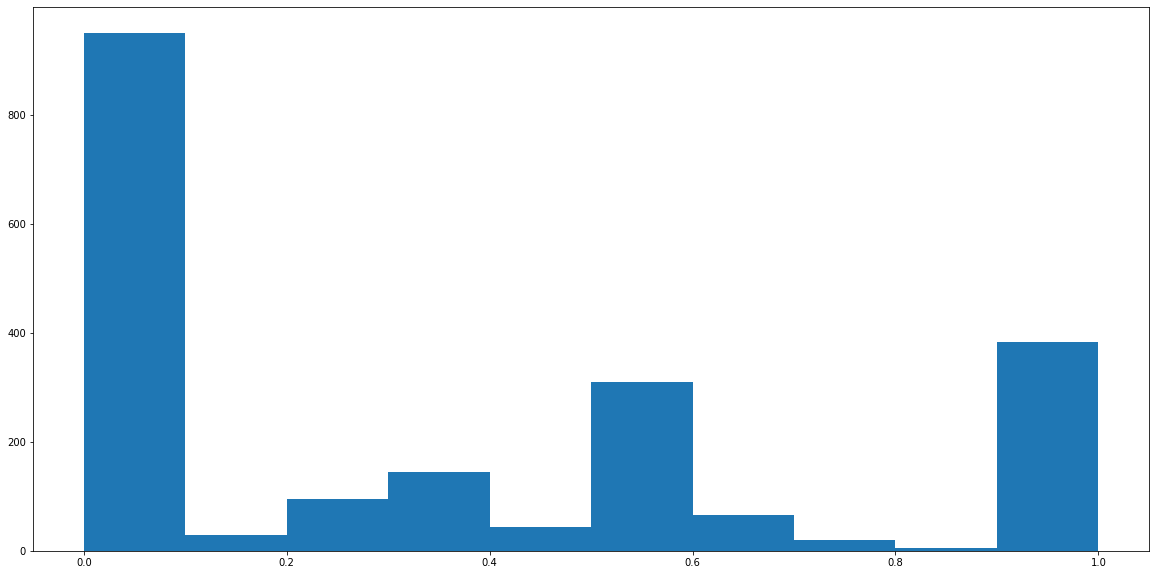

In [84]:
#Plotting recall distribution 
recalls = calculate_recall_distribution(X_test, nb_tfidf_pred, y_test)
ids = [item[0] for item in recalls ]
recalls = [item[1] for item in recalls ]
recalls_df = pd.DataFrame(ids , columns=['id'])
recalls_df['recalls']= recalls

import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))

plt.hist(recalls_df['recalls'])
plt.show()

## Using Tf-idf with Random Forest

In [85]:
#Performing Cross Validation for the best combination of parameters

tfidf_rfc = RandomForestClassifier(random_state=42,n_jobs=-1, class_weight = 'balanced')
param_grid = {
    
    'n_estimators': [200, 500],
    'max_depth':[4,5,6,7,8]
}

In [86]:
# Find the best parameters for both the feature extraction and the classifier
tfidf_CV_rfc = GridSearchCV(estimator=tfidf_rfc, param_grid=param_grid, cv=5, scoring = 'f1')
tfidf_CV_rfc.fit(tf_idf_vectors, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight='balanced',
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=-1,
                                              oob_score=False, random_state=42,
                              

In [87]:
tfidf_CV_rfc.best_params_

{'max_depth': 8, 'n_estimators': 500}

In [88]:
# Now use best params for rf
rf_tfidf_pred=tfidf_CV_rfc.predict(X_test_tfidf)

In [89]:
#Accuracy
metrics.accuracy_score(y_test, rf_tfidf_pred)

0.8118666666666666

In [90]:
#Confusion matrix 
print(f'Confusion Matrix: \n {metrics.confusion_matrix(y_test, rf_tfidf_pred)}')

Confusion Matrix: 
 [[19888  5179]
 [  465  4468]]


In [91]:
#Classification report
print(f'Classification Report: \n\n {metrics.classification_report(y_test, rf_tfidf_pred)}')

Classification Report: 

               precision    recall  f1-score   support

           0       0.98      0.79      0.88     25067
           1       0.46      0.91      0.61      4933

    accuracy                           0.81     30000
   macro avg       0.72      0.85      0.74     30000
weighted avg       0.89      0.81      0.83     30000



## Saving Dataframes to add more features later


In [92]:
type(tf_idf_vectors)

scipy.sparse.csr.csr_matrix

In [93]:
#Save tfidf sparse matrices  
import scipy.sparse
scipy.sparse.save_npz('./datasets/train_sparse_matrix.npz', tf_idf_vectors)
scipy.sparse.save_npz('./datasets/test_sparse_matrix.npz', X_test_tfidf)

In [94]:
#Save feature names 
import pickle
with open("tfidf_features.txt", 'wb') as f:
    pickle.dump(tfidf.get_feature_names(), f) 

In [95]:
#Save training and testing dataframes (without tfidf)
X_train.to_csv('./datasets/wikihow_X_train.csv', index=False)
X_test.to_csv('./datasets/wikihow_X_test.csv', index=False)

In [96]:
#Save labels  
y_train.to_csv('./datasets/wikihow_y_train.csv', index=False)
y_test.to_csv('./datasets/wikihow_y_test.csv', index=False)